## Week 1 : Data Manipulation and Exploration
```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini
```
<hr>


### Content
```
Lab Plan
1. Data exploration
2. Dealing with categorical features
3. Dealing with missing data
4. Features Scaling
5. Trainset splitting
6. Data Visualization

```

<hr>


![](https://www.gosmar.eu/machinelearning/wp-content/uploads/2021/01/MLOps_pipeline_scaling3.png)

## Installing libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Read Data with Pandas

In [2]:
football_df = pd.read_csv('./football_data.csv', parse_dates=['Date'])

## 2. Exploratory Data Analysis

In [3]:
football_df.shape

(10000, 102)

We have 102 features and 10000 observations

In [4]:
football_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 102 entries, Date to Season
dtypes: datetime64[ns](1), float64(33), int64(31), object(37)
memory usage: 7.8+ MB


There are 1 datetime, 64 numeric (33 float and 31 int) and 37 categorical features

In [5]:
football_df.iloc[:,4:].head(5)

,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,yrdln,yrdline100,ydstogo,ydsnet,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,NaN,02:00,2,1920.0,5.0,SD,44.0,44.0,0,22,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,2016
1,1.0,02:00,2,1920.0,0.0,SD,47.0,53.0,10,68,...,0.330475,0.968025,0.031975,0.940170,0.059830,0.031975,0.027855,0.024299,0.003556,2016
2,1.0,01:50,2,1910.0,10.0,CAR,7.0,7.0,7,66,...,NaN,0.940170,0.059830,0.947575,0.052425,0.059830,-0.007405,NaN,NaN,2016
3,2.0,01:17,2,1877.0,33.0,CAR,9.0,9.0,9,66,...,-3.766159,0.947575,0.052425,0.953601,0.046399,0.052425,-0.006025,0.036136,-0.042161,2016
4,3.0,01:08,2,1868.0,9.0,CAR,9.0,9.0,9,75,...,0.000000,0.953601,0.046399,0.912354,0.087646,0.046399,0.041247,0.041247,0.000000,2016


From the first 5 observations it can be see clearly that there are almost empty observations (like the zero obs.)

And we can extract the `Date` and `time` to analyze distributions of features: years, months, days, time_0 and time_1

In [3]:
football_df = pd.concat([football_df, football_df['Date'].dt.year.rename('Year'), 
                                      football_df['Date'].dt.month.rename('Month'), 
                                      football_df['Date'].dt.day.rename('Day'), 
                                      football_df['Date'].dt.weekday.rename('Weekday')], axis=1)

Before splitting the `time` we need to *drop* the rows with `Nan` values in `time` column, because `Nan` isn't splitted. Thanksfully, `Nan` observations not so much.

In [4]:
isna_time = football_df.loc[football_df['time'].isna()]
print(f"There are observations with Nan time: {len(isna_time)} ({len(isna_time)/len(football_df)*100}%). They will be drop in the dataframe (GameID): \n{isna_time['GameID']}")
football_df.drop(isna_time.index, inplace=True, axis=0)
print(f"Obtained dataframe has {len(football_df)} observations")
football_df[['time_0', 'time_1']] = football_df['time'].str.split(':', expand=True).astype(int)

# football_df.drop(['Date', 'time'], axis=1, inplace=True)

There are observations with Nan time: 8 (0.08%). They will be drop in the dataframe (GameID): 
244     2016121102
2075    2016121801
2116    2016121801
2160    2016121801
4493    2016122400
4545    2016122400
4583    2016122400
4636    2016122400
Name: GameID, dtype: int64
Obtained dataframe has 9992 observations


### 2.1 Time-dedicated features

First of all it needs to understand what is it time_0 and time_1. Let's see the distributions.

In [8]:
football_df[['time_0', 'time_1']].describe()

,time_0,time_1
count,9992.000000,9992.000000
mean,6.409628,27.527022
std,4.688755,18.311544
min,0.000000,0.000000
25%,2.000000,11.000000
50%,6.000000,27.000000
75%,10.000000,43.000000
max,15.000000,59.000000


<Axes: xlabel='time_1', ylabel='Count'>

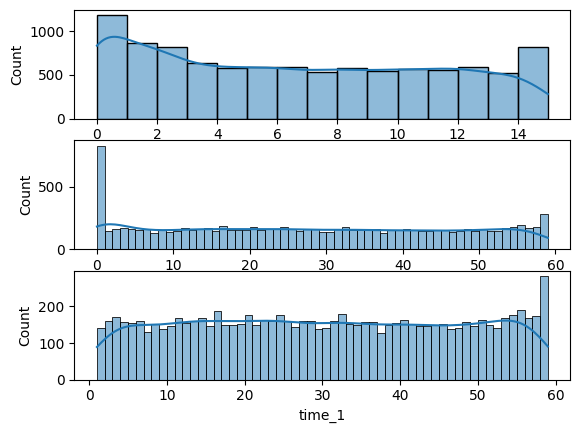

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plt.rcParams['figure.figsize'] = (8, 10)

sns.histplot(football_df['time_0'], kde=True, ax=axes[0], bins=15) # min-max=[0, 15]
sns.histplot(football_df['time_1'], kde=True, ax=axes[1], bins=59) # min-max=[0, 59]
without_zero_time_1 = football_df[football_df['time_1']!=0]['time_1']
sns.histplot(without_zero_time_1, kde=True, ax=axes[2], bins=58)


How can it was shown above, we assume that `time_0` is **hours** 
- (?: but it may be **minutes**, because `time_0` range in [0,15], and then `time_1` will be **seconds**) 

and `time_1` is **minutes**

We also see that minutes often set to zero value.

In [10]:
football_df[['Year', 'Month', 'Day','Weekday']].describe()

,Year,Month,Day,Weekday
count,9992.000000,9992.000000,9992.000000,9992.000000
mean,2016.282126,8.896617,13.912430,5.329864
std,0.450057,4.950624,9.119577,1.442758
min,2016.000000,1.000000,1.000000,0.000000
25%,2016.000000,1.000000,1.000000,5.000000
50%,2016.000000,12.000000,18.000000,6.000000
75%,2017.000000,12.000000,24.000000,6.000000
max,2017.000000,12.000000,26.000000,6.000000


<Axes: xlabel='Day', ylabel='Count'>

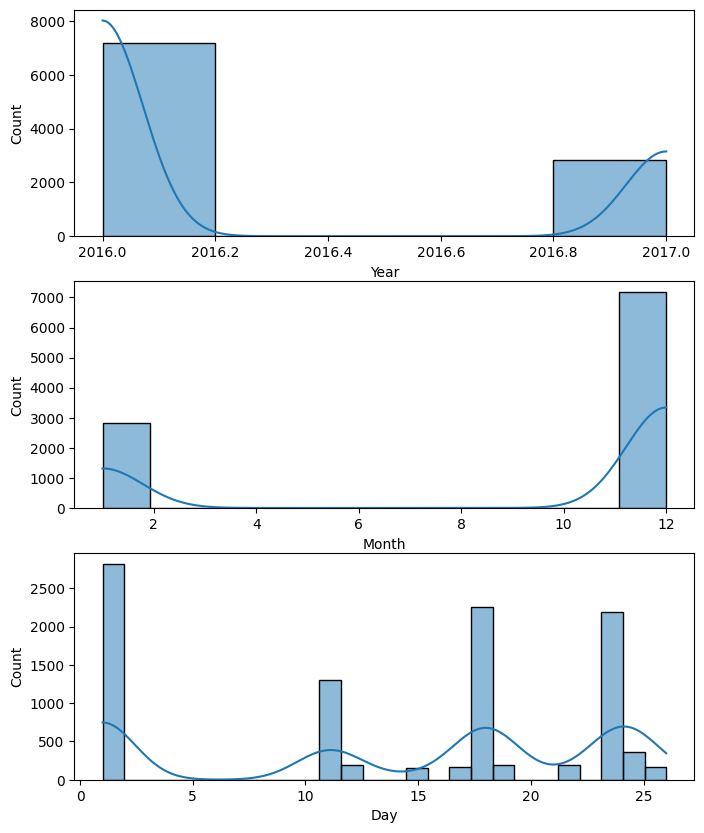

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plt.rcParams['figure.figsize'] = (8, 10)

sns.histplot(football_df['Year'], kde=True, ax=axes[0], bins=5)
sns.histplot(football_df['Month'], kde=True, ax=axes[1], bins=12) # min-max=[1, 12]
sns.histplot(football_df['Day'], kde=True, ax=axes[2], bins=26) # min-max=[0, 26]


Above histograms shows us the dataset may cover the New Year's Eve period 

In [12]:
football_df['Datetime'] = pd.to_datetime(dict(year=football_df['Date'].dt.year, 
                    month=football_df['Date'].dt.month, 
                    day=football_df['Date'].dt.day,
                    hour=football_df['time_0'], # fix, if it isn't true
                    minute=football_df['time_1']))


(2016-12-10 23:28:51.599999999, 2016-12-12 01:57:00]    1339
(2016-12-15 07:48:00, 2016-12-16 09:45:00]                77
(2016-12-19 15:36:00, 2016-12-20 17:33:00]                 0
(2016-12-23 23:24:00, 2016-12-25 01:21:00]              2256
(2016-12-28 07:12:00, 2016-12-29 09:09:00]                 0
Name: count, dtype: int64

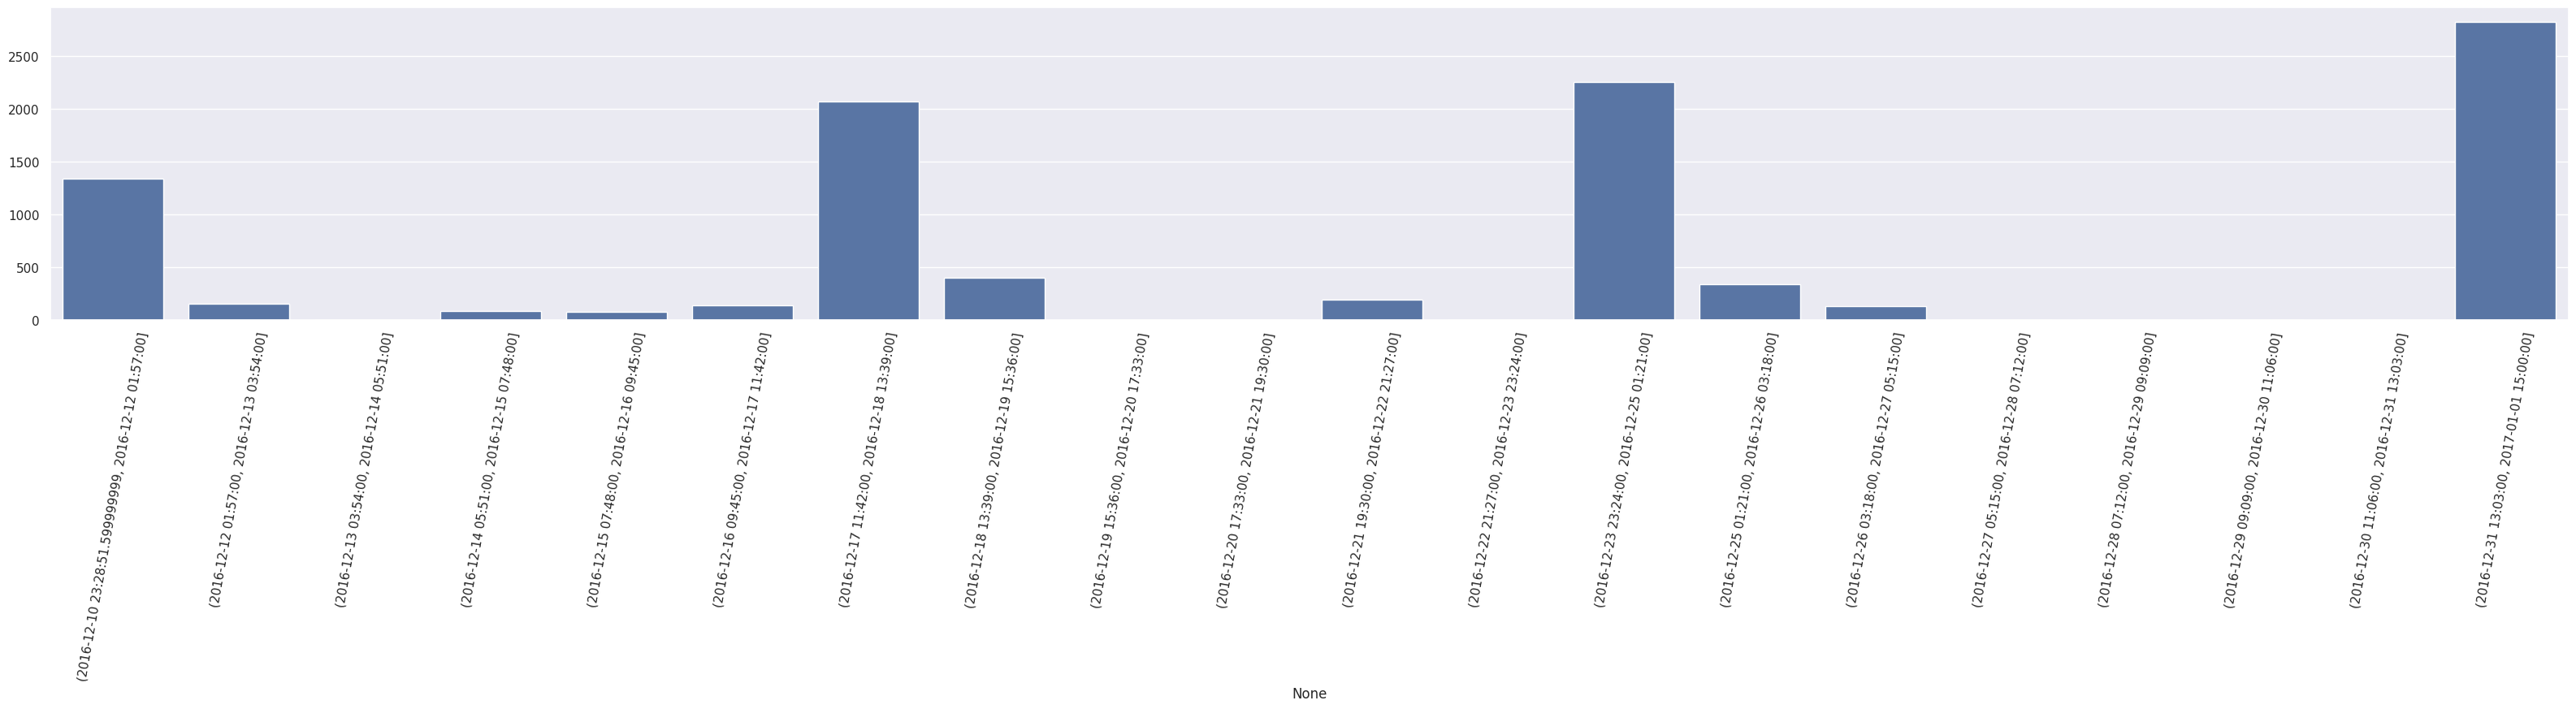

In [48]:
bins_datetime = football_df['Datetime'].value_counts(sort=False, bins=20)
_, ax = plt.subplots(figsize=(40, 5))
bins_datetime_plot = sns.barplot(x=bins_datetime.index.astype(str), 
                                 y=bins_datetime.values)
bins_datetime_plot.tick_params(axis='x', rotation=80)
bins_datetime[::4]


That's what needed to be checked, the dataset cover the New Year's Eve period.

What interesting, we see the fluctuation with extreme points in bins: [10, 12], [17, 18], [23, 25], [31, 01]. 
It may be days off.

<Axes: xlabel='Weekday', ylabel='Count'>

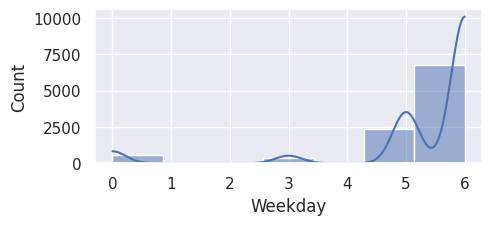

In [59]:
plt.subplots(figsize=(5,2))
sns.histplot(football_df['Weekday'], kde=True, bins=7)

Yes. The major part of games falls on the days off.

### 2.2 Categorical features

In [9]:
threshold = 50

In [6]:
cat_features = football_df.select_dtypes('object').columns
print(f"Number categorical featues: {len(cat_features)}")
print(football_df.loc[:, cat_features].info())

Number categorical featues: 37
<class 'pandas.core.frame.DataFrame'>
Index: 9992 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   time              9992 non-null   object
 1   SideofField       9977 non-null   object
 2   posteam           9353 non-null   object
 3   DefensiveTeam     9353 non-null   object
 4   desc              9992 non-null   object
 5   ExPointResult     258 non-null    object
 6   TwoPointConv      18 non-null     object
 7   DefTwoPoint       2 non-null      object
 8   PuntResult        528 non-null    object
 9   PlayType          9992 non-null   object
 10  Passer            4138 non-null   object
 11  Passer_ID         4193 non-null   object
 12  PassOutcome       4138 non-null   object
 13  PassLength        4122 non-null   object
 14  PassLocation      4122 non-null   object
 15  Interceptor       112 non-null    object
 16  Rusher            2968 non-null   

#### 2.2.1 >50% non-null features

In [7]:
football_df_nan_imputed = football_df.fillna("NaN").copy()
cat_nonnull_features = cat_features[football_df.loc[:,cat_features].isna().sum(0) < len(football_df) * 50 / 100]
cat_nonnull_features

Index(['time', 'SideofField', 'posteam', 'DefensiveTeam', 'desc', 'PlayType',
       'Tackler1', 'HomeTeam', 'AwayTeam'],
      dtype='object')

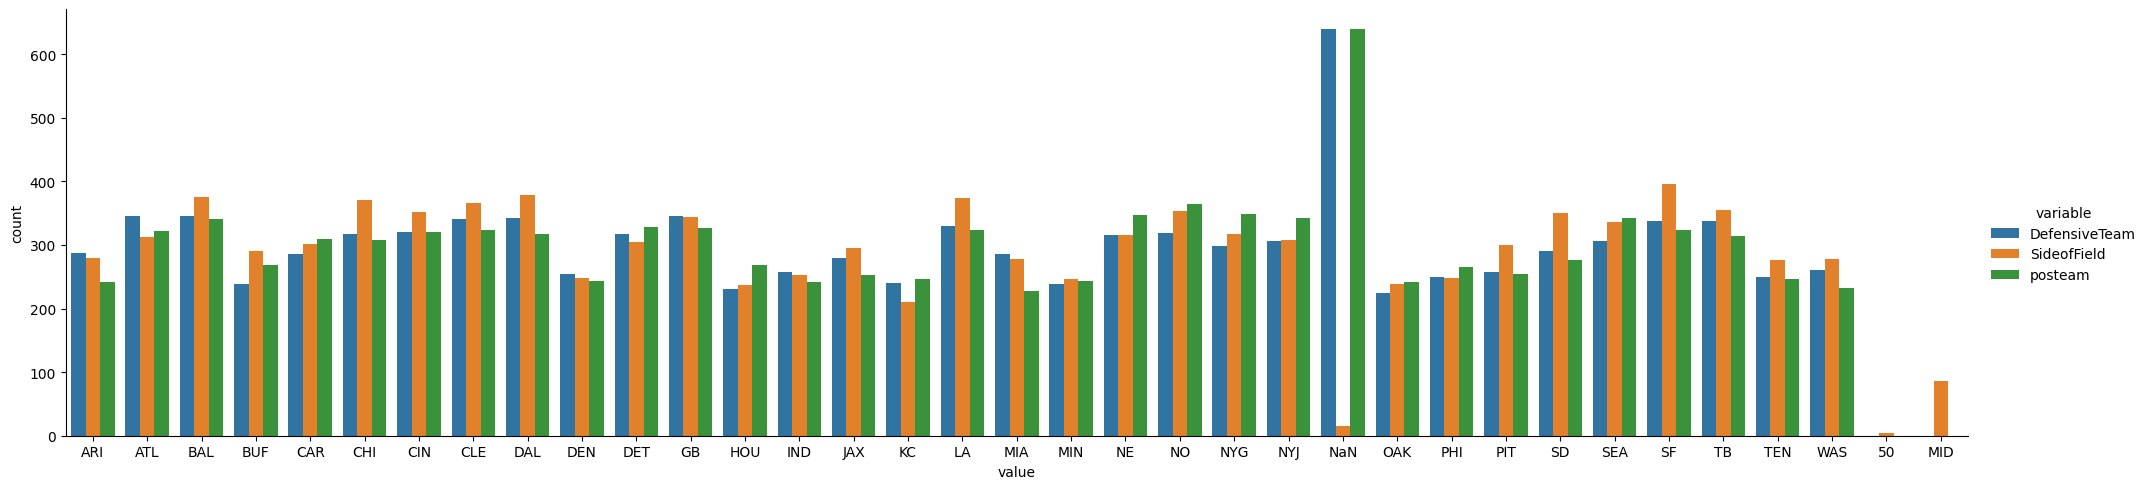

In [12]:
df_uniques = pd.melt(
    frame=football_df_nan_imputed,
    value_vars=["SideofField", "posteam", "DefensiveTeam"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(x="value", y="count", hue="variable", data=df_uniques, kind="bar", height=5, aspect=20/5)
# _ = plt.xticks(rotation='vertical')

- TODO: get insight from above figure. Ideas: some of values have order throw variable

In [13]:
print(f"The most frequency descriptions: feature {football_df_nan_imputed.value_counts('desc')[:5]}\n \
      amount to: {football_df_nan_imputed.value_counts('desc')[:5].values.sum()} \n\
      \rAnd the remaining {football_df_nan_imputed.value_counts('desc')[5:10]} \n\
      amount to: {football_df_nan_imputed.value_counts('desc')[5:].values.sum()}\n\
      from that follows: feature desc. mostly have unique values.\n\
      Overall number of unique values are: {football_df_nan_imputed.value_counts('desc').size}")


The most frequency descriptions: feature desc
Two-Minute Warning    104
END QUARTER 3          53
END QUARTER 1          51
END GAME               44
END QUARTER 2          39
Name: count, dtype: int64
       amount to: 291 
And the remaining desc
J.Myers kicks 65 yards from JAX 35 to end zone, Touchback.         18
M.Bryant extra point is GOOD, Center-J.Harris, Holder-M.Bosher.    17
M.Bosher kicks 65 yards from ATL 35 to end zone, Touchback.        16
M.Crosby extra point is GOOD, Center-B.Goode, Holder-J.Schum.      15
S.Gostkowski kicks 65 yards from NE 35 to end zone, Touchback.     15
Name: count, dtype: int64 
      amount to: 9701
      from that follows: feature desc. mostly have unique values.
      Overall number of unique values are: 9263


Tackler1
NaN               4122
D.Jones             46
J.Collins           44
S.Moore             40
K.Alexander         39
                  ... 
C.Lewis-Harris       1
S.Brown              1
S.Charles            1
C.Leno               1
Z.Zenner             1
Name: count, Length: 857, dtype: int64

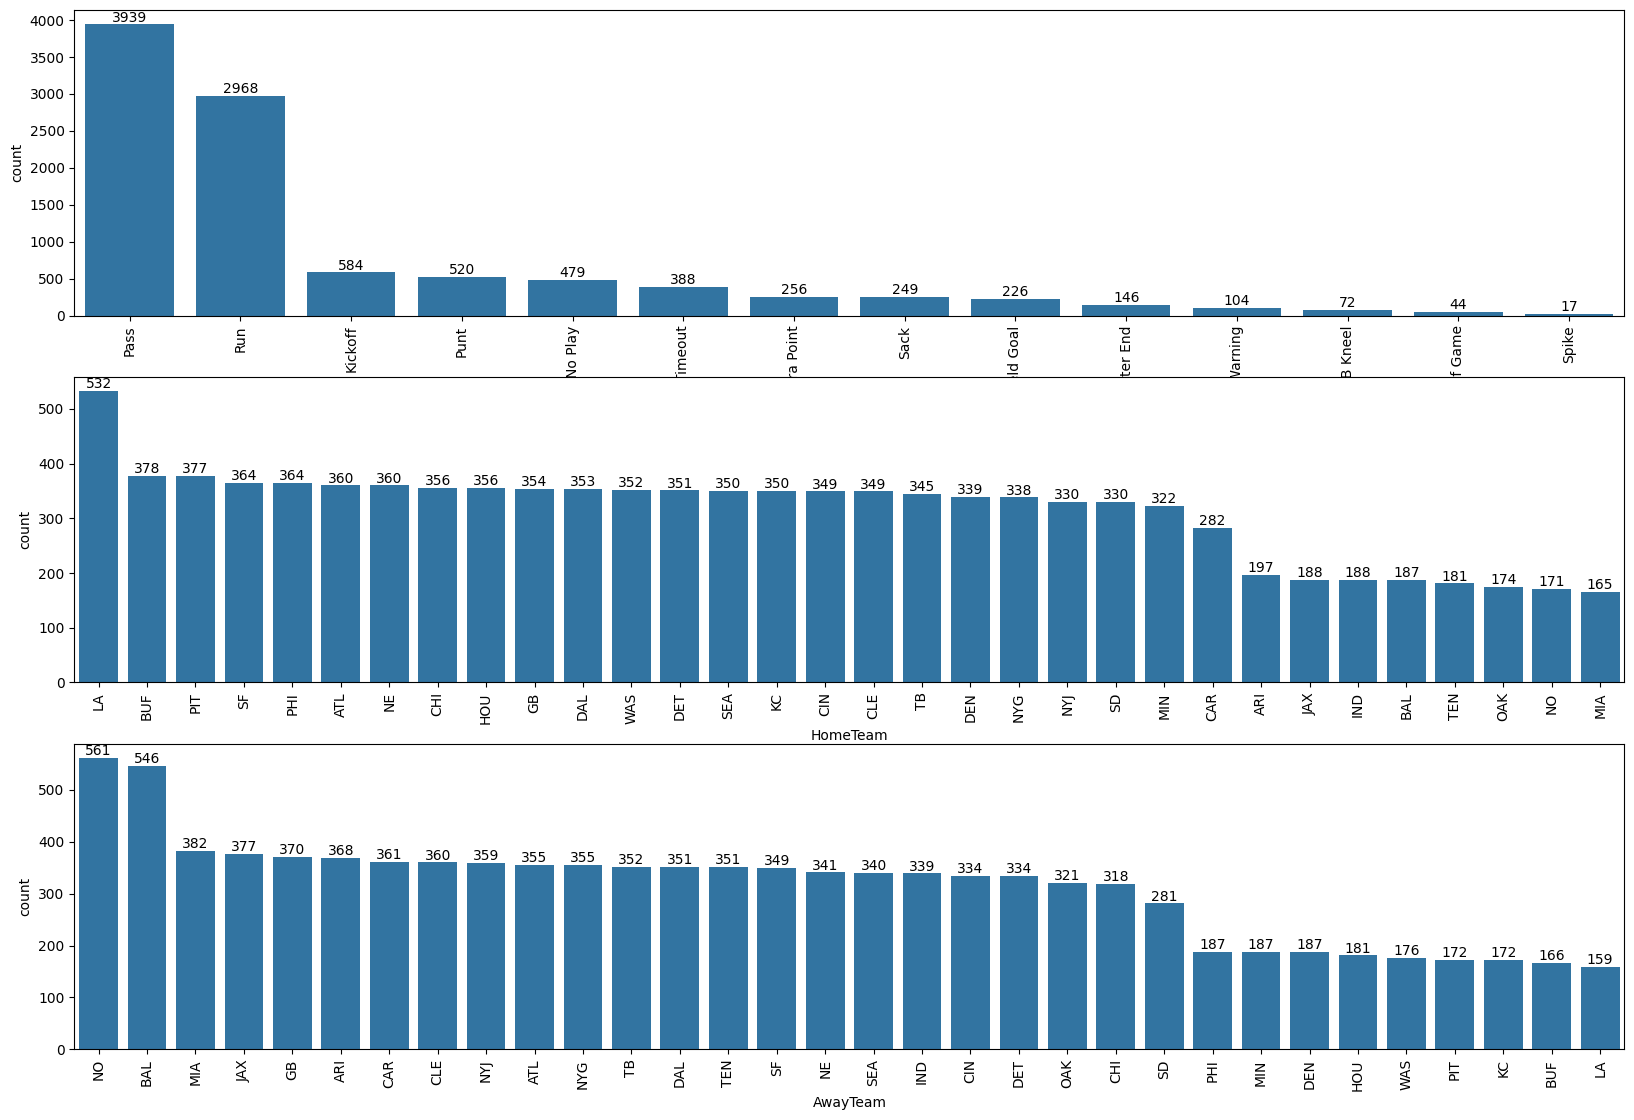

In [71]:
review_cols = ['PlayType', 'HomeTeam', 'AwayTeam']
_, axes = plt.subplots(len(review_cols), 1, figsize=(20, len(review_cols) * 4.5))
for idx, col in enumerate(review_cols):
    sns.countplot(football_df_nan_imputed, x=col, ax=axes[idx], order=football_df_nan_imputed[col].value_counts().index)
    axes[idx].bar_label(axes[idx].containers[0])
    axes[idx].tick_params(axis='x', rotation=90)

football_df_nan_imputed.value_counts('Tackler1')

#### 2.2.2 <=50% non-null features

In [10]:
cat_null_features = cat_features[football_df.loc[:, cat_features].isna().sum(0) >= len(football_df) * threshold / 100]
cat_null_features

Index(['ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'PuntResult', 'Passer',
       'Passer_ID', 'PassOutcome', 'PassLength', 'PassLocation', 'Interceptor',
       'Rusher', 'Rusher_ID', 'RunLocation', 'RunGap', 'Receiver',
       'Receiver_ID', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler2',
       'FieldGoalResult', 'RecFumbTeam', 'RecFumbPlayer', 'ChalReplayResult',
       'PenalizedTeam', 'PenaltyType', 'PenalizedPlayer', 'Timeout_Team'],
      dtype='object')

In [15]:
football_df_nan_imputed.value_counts(['ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'PuntResult','PassLength','PassOutcome','PassLocation'])

ExPointResult  TwoPointConv  DefTwoPoint  PuntResult  PassLength  PassOutcome      PassLocation
NaN            NaN           NaN          NaN         NaN         NaN              NaN             5063
                                                      Short       Complete         right            890
                                                                                   left             805
                                                                                   middle           528
                                          Clean       NaN         NaN              NaN              524
                                          NaN         Short       Incomplete Pass  right            465
                                                                                   left             415
Made           NaN           NaN          NaN         NaN         NaN              NaN              241
NaN            NaN           NaN          NaN         Short       Incomp

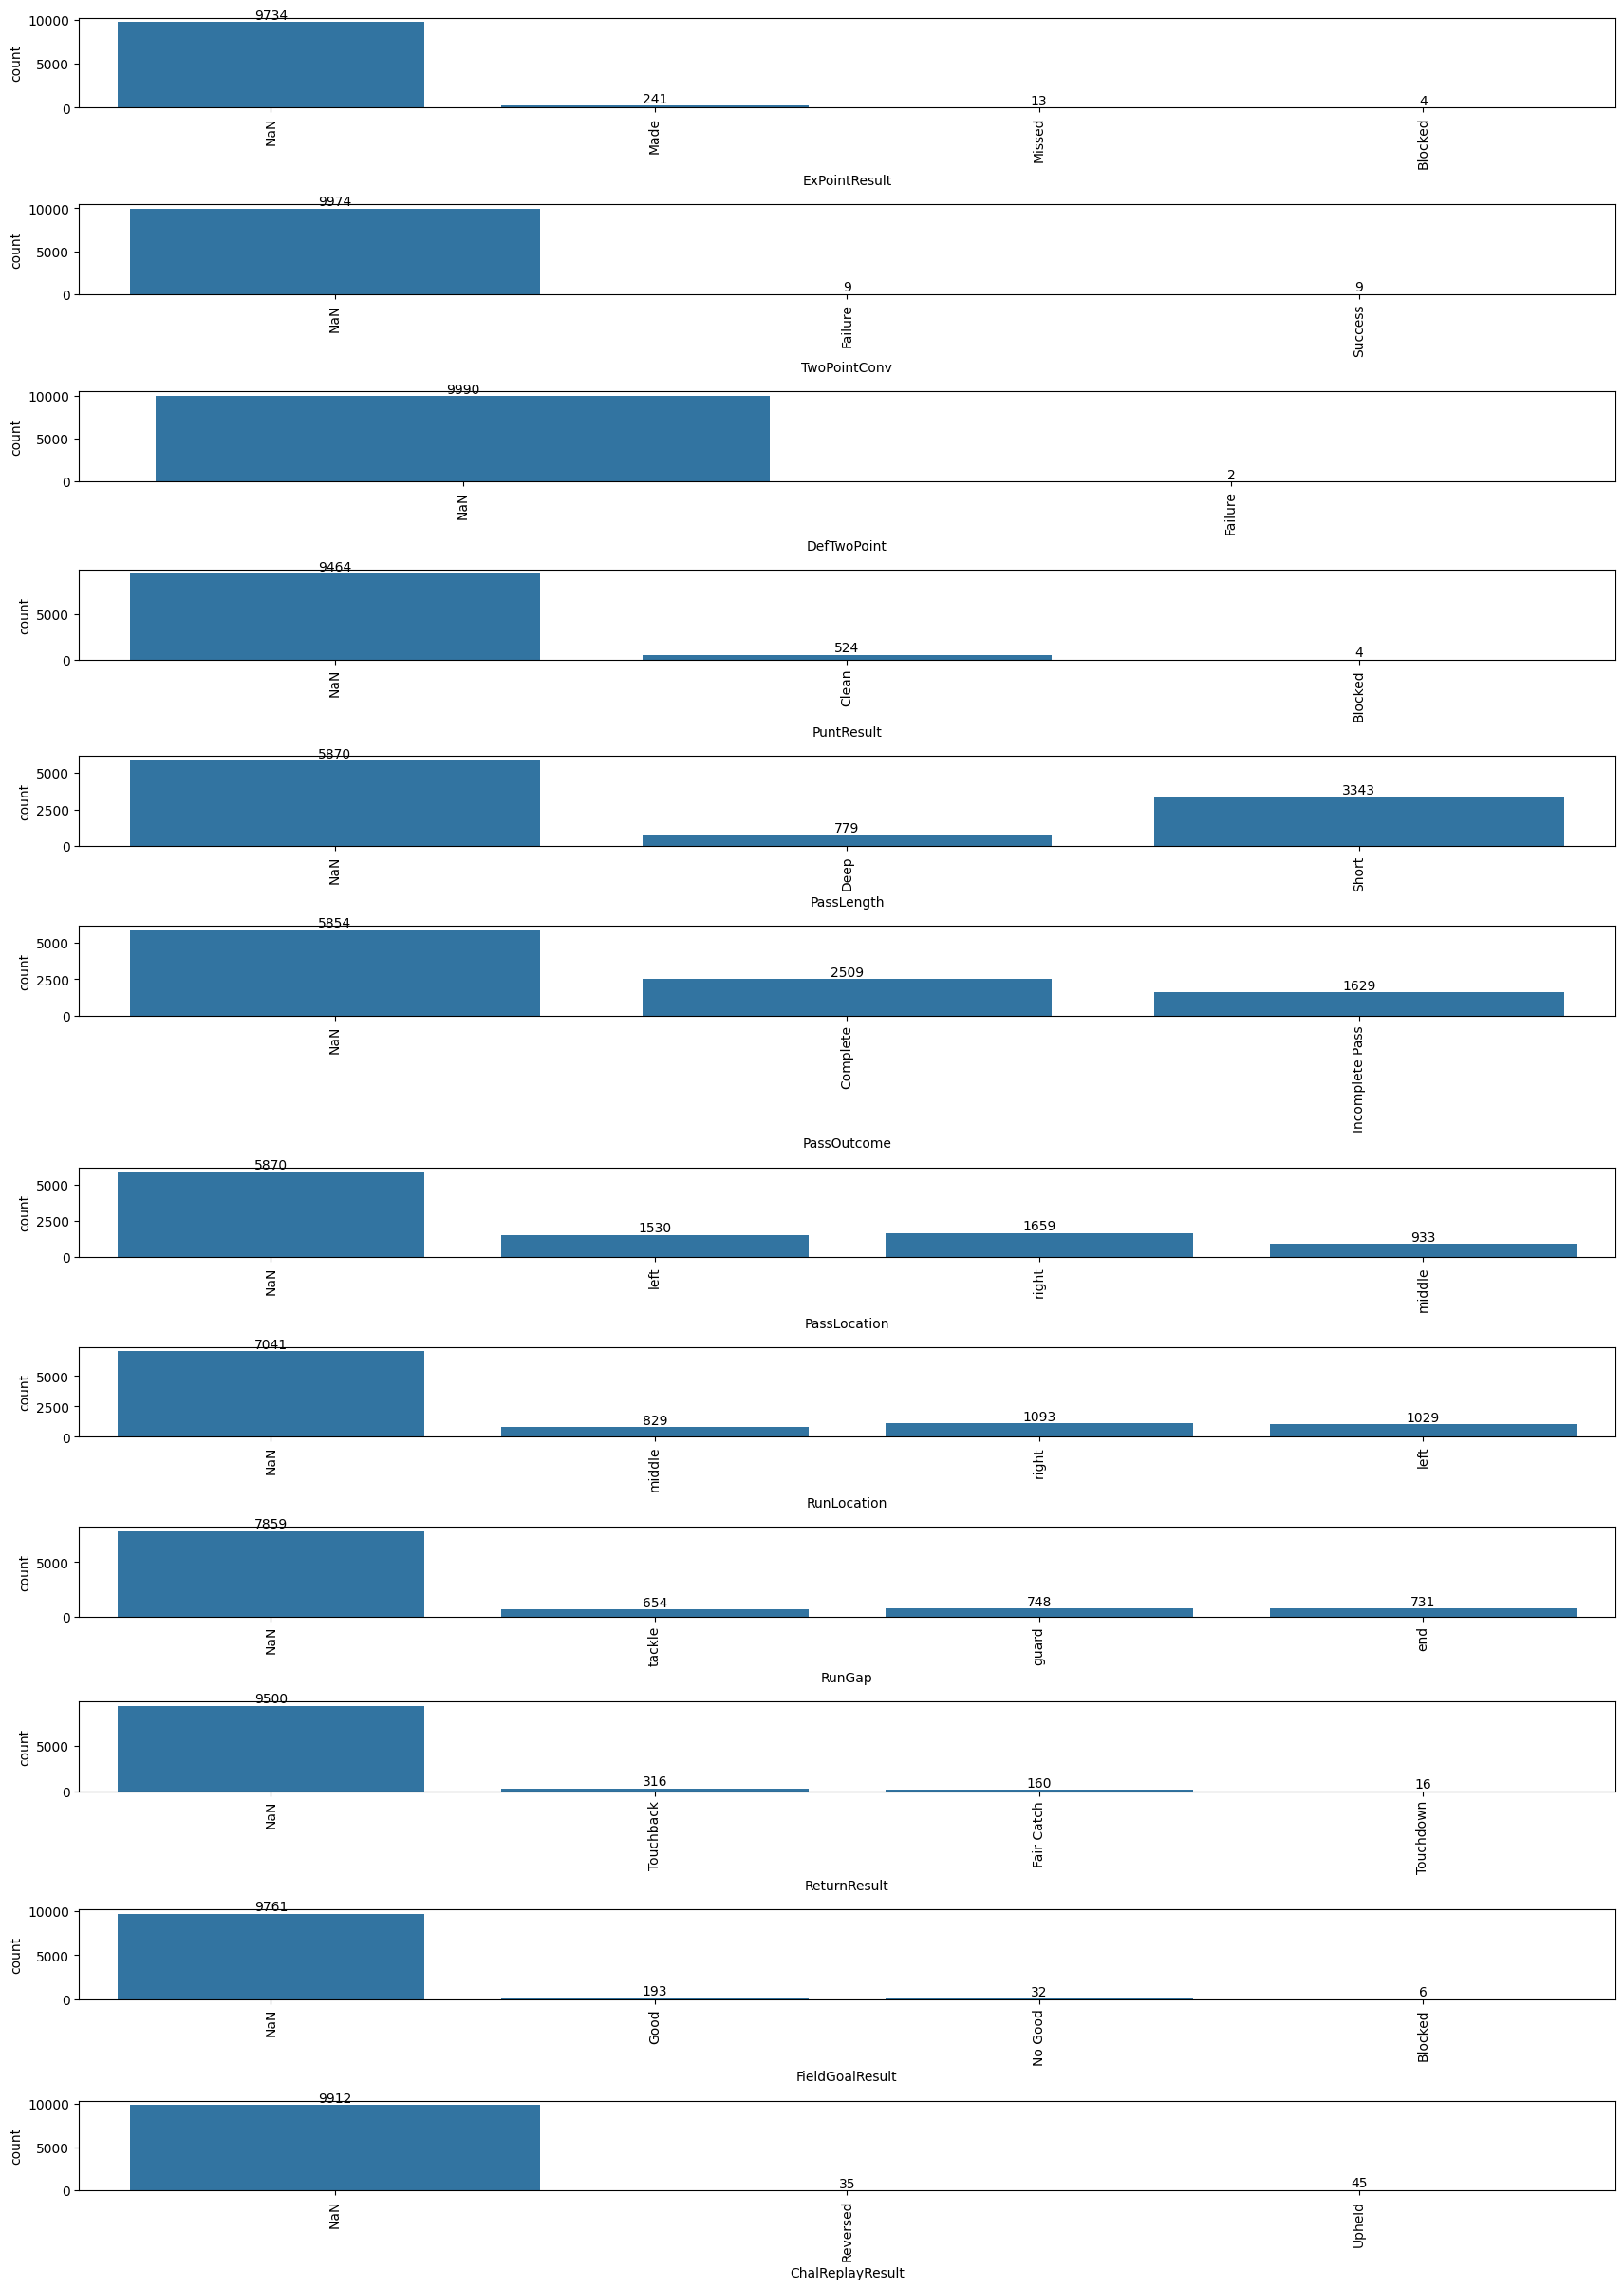

In [92]:
reviewed_cols = [
    'ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'PuntResult', 
    'PassLength','PassOutcome','PassLocation',
    'RunLocation', 'RunGap','ReturnResult','FieldGoalResult','ChalReplayResult',
    ]
fig, axes = plt.subplots(len(reviewed_cols), 1, figsize=(17, len(reviewed_cols) * 2), constrained_layout=True)
for idx, col in enumerate(reviewed_cols):
    sns.countplot(football_df_nan_imputed, x=col, ax=axes[idx])
    axes[idx].bar_label(axes[idx].containers[0])
    axes[idx].tick_params(axis='x', rotation=90)

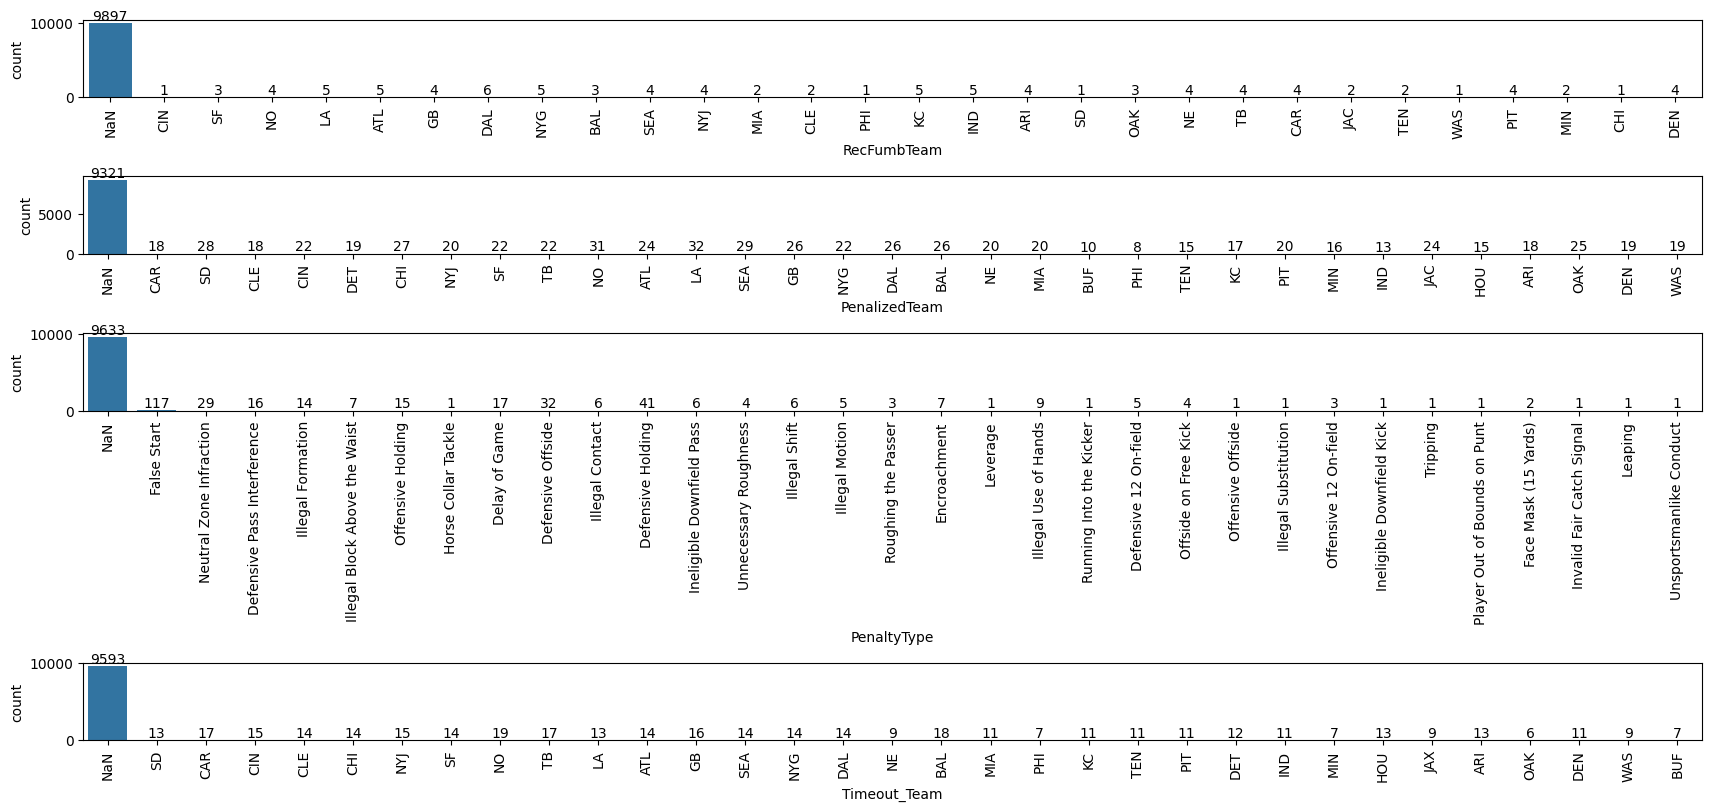

In [91]:
reviewed_cols = [
    'RecFumbTeam','PenalizedTeam', 'PenaltyType','Timeout_Team'
    ]
fig, axes = plt.subplots(len(reviewed_cols), 1, figsize=(17, len(reviewed_cols) * 2), constrained_layout=True)
for idx, col in enumerate(reviewed_cols):
    sns.countplot(football_df_nan_imputed, x=col, ax=axes[idx])
    axes[idx].bar_label(axes[idx].containers[0])
    axes[idx].tick_params(axis='x', rotation=90)

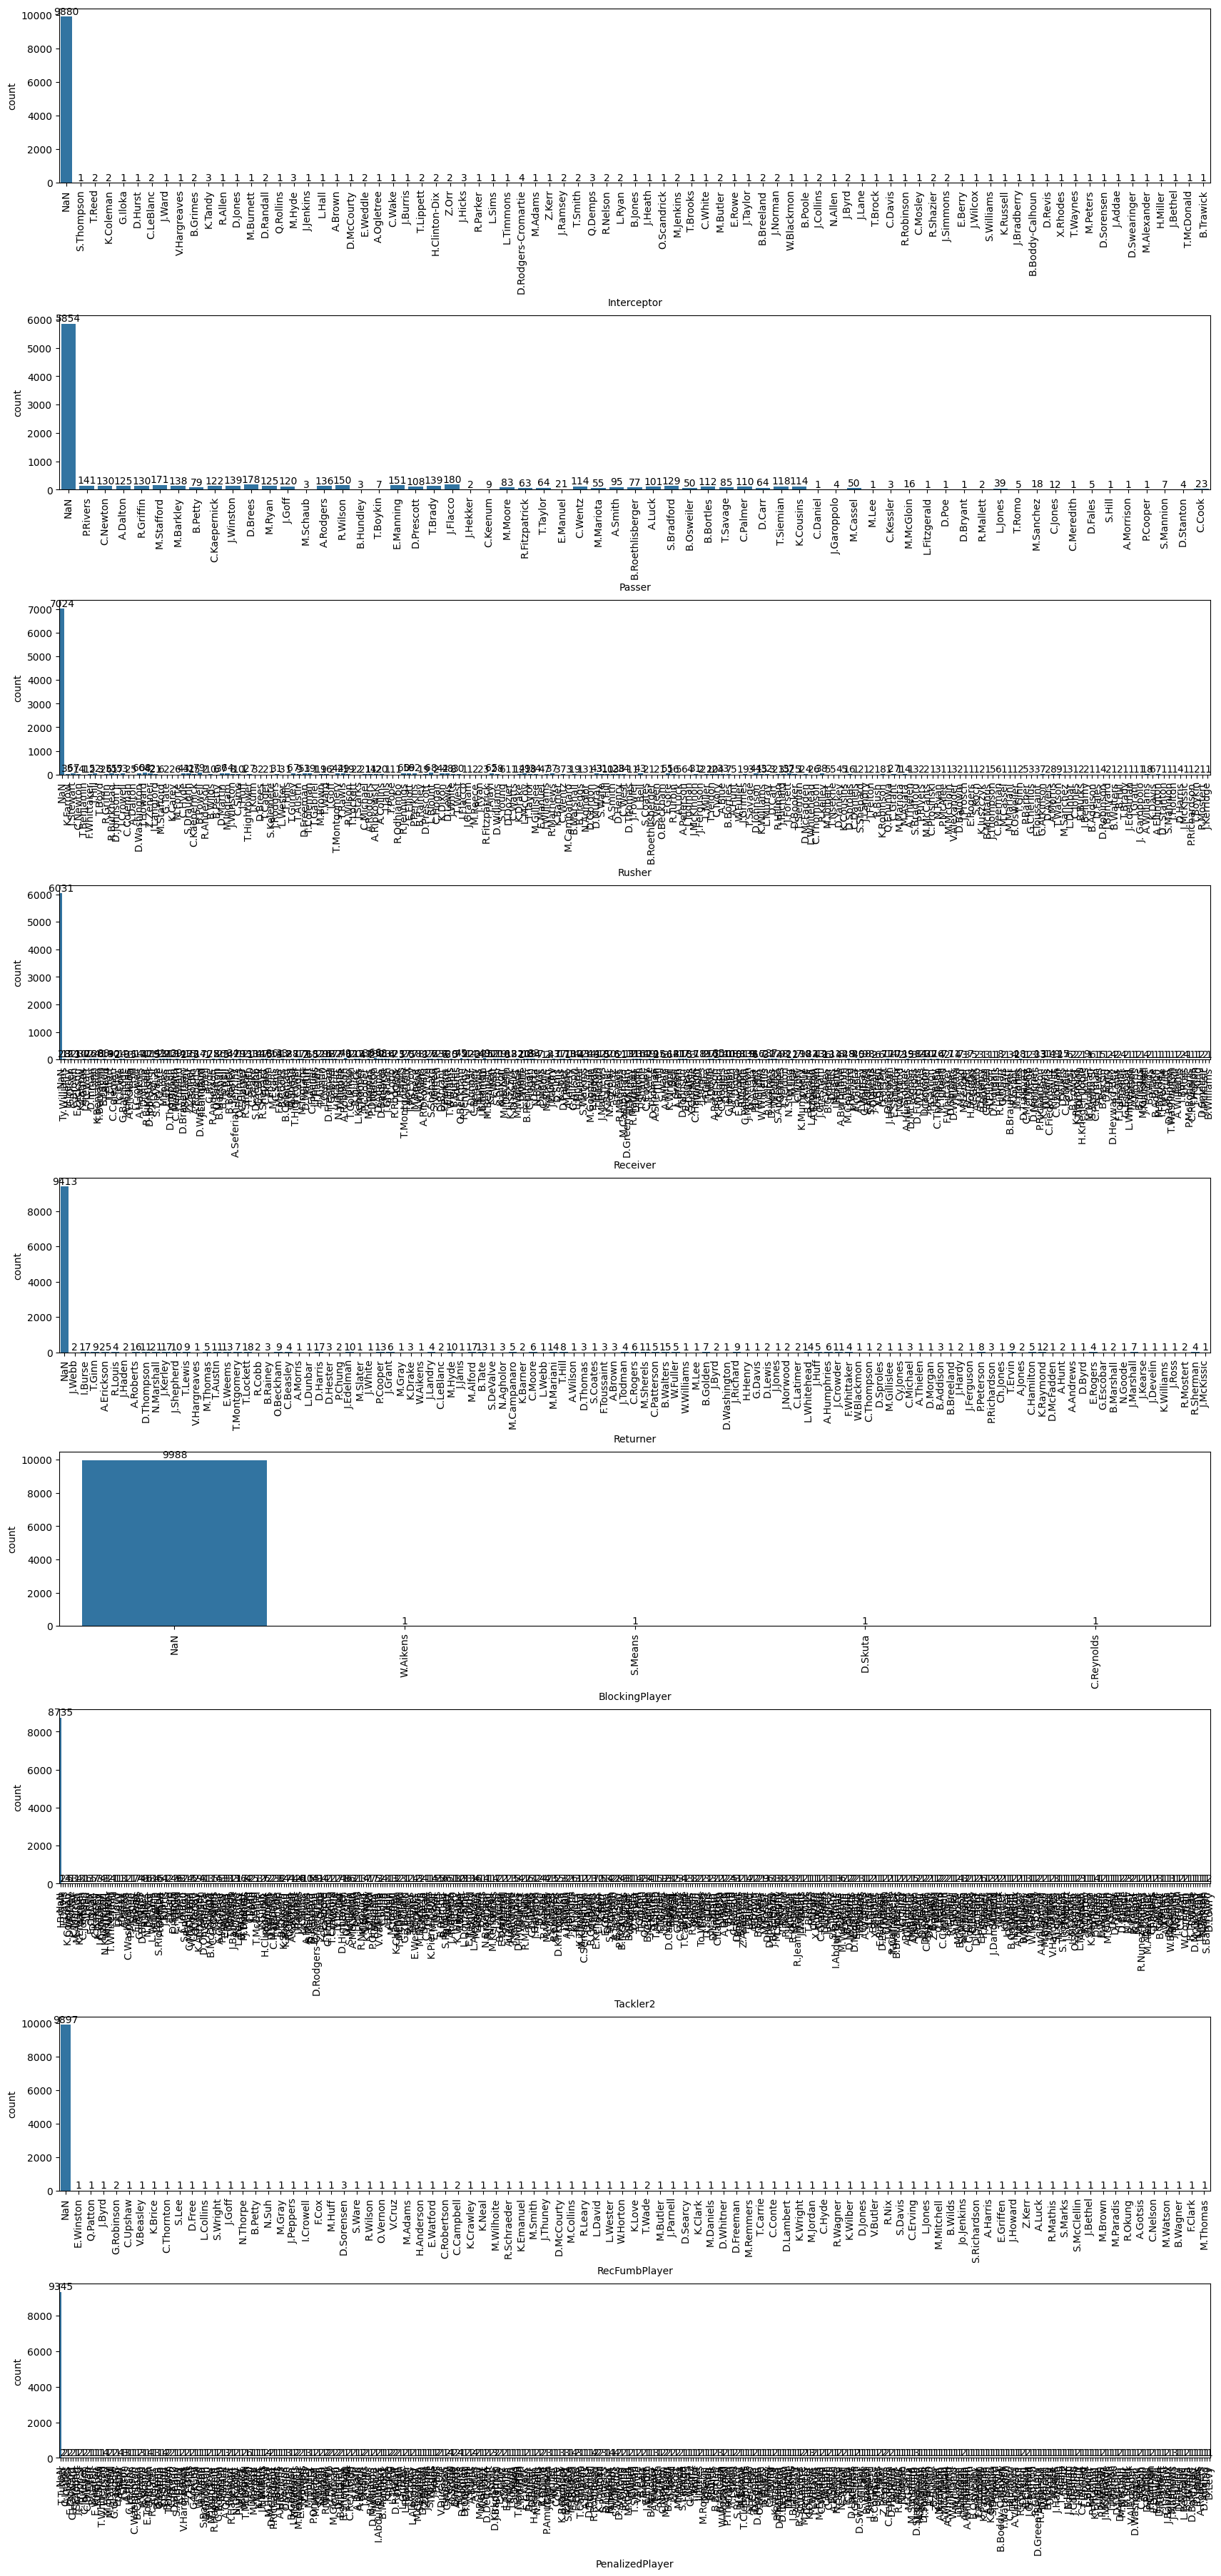

In [93]:
reviewed_cols = [
    'Interceptor', 'Passer', 'Rusher','Receiver','Returner','BlockingPlayer','Tackler2','RecFumbPlayer','PenalizedPlayer'
    ]
fig, axes = plt.subplots(len(reviewed_cols), 1, figsize=(17, len(reviewed_cols) * 4), constrained_layout=True)
for idx, col in enumerate(reviewed_cols):
    sns.countplot(football_df_nan_imputed, x=col, ax=axes[idx])
    axes[idx].bar_label(axes[idx].containers[0])
    axes[idx].tick_params(axis='x', rotation=90)

In [10]:
football_df.describe()

,Date,GameID,Drive,qtr,down,TimeUnder,TimeSecs,PlayTimeDiff,yrdln,yrdline100,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
count,10000,1.000000e+04,10000.000000,10000.000000,8448.000000,10000.000000,9992.000000,9984.000000,9980.000000,9980.000000,...,3929.000000,9357.000000,9357.000000,9309.000000,9309.000000,10000.000000,9.845000e+03,3930.000000,3923.000000,10000.0
mean,2016-12-22 15:45:04.320000,2.016372e+09,12.444900,2.584500,1.991951,7.322400,1686.264011,20.739283,28.566433,47.859218,...,-0.400785,0.547408,0.453126,0.547667,0.452708,0.470946,1.673133e-03,0.014596,-0.009764,2016.0
min,2016-12-11 00:00:00,2.016121e+09,1.000000,1.000000,1.000000,0.000000,-849.000000,0.000000,1.000000,1.000000,...,-12.156367,0.000000,0.000000,0.000000,0.000000,0.000000,-9.719480e-01,-0.943119,-0.939447,2016.0
25%,2016-12-18 00:00:00,2.016122e+09,6.000000,2.000000,1.000000,3.000000,772.000000,5.000000,19.000000,29.000000,...,-0.950799,0.298087,0.183309,0.295898,0.179571,0.172491,-1.375776e-02,-0.009758,-0.017638,2016.0
50%,2016-12-24 00:00:00,2.016122e+09,12.000000,3.000000,2.000000,7.000000,1800.000000,18.000000,30.000000,48.000000,...,0.000000,0.565156,0.435096,0.568334,0.431754,0.486653,-7.985673e-07,0.004151,0.000000,2016.0
75%,2017-01-01 00:00:00,2.017010e+09,18.000000,4.000000,3.000000,11.000000,2575.000000,37.000000,38.000000,69.000000,...,0.469628,0.817714,0.702465,0.820549,0.705156,0.750169,1.278280e-02,0.033391,0.009991,2016.0
max,2017-01-01 00:00:00,2.017010e+09,30.000000,5.000000,4.000000,15.000000,3600.000000,908.000000,50.000000,99.000000,...,8.079540,1.000000,1.000000,1.000000,1.000000,1.000000,9.739204e-01,0.898214,0.932194,2016.0
std,NaN,3.996451e+05,7.075561,1.131542,1.006399,4.685216,1064.437980,20.795996,12.533362,24.737534,...,2.008014,0.300660,0.300744,0.302591,0.302650,0.319106,4.684680e-02,0.056720,0.065689,0.0


### 2.3 Quantitative features

In [96]:
num_features = football_df.select_dtypes('number').columns
print(f"Number quantitative featues: {len(num_features)}")
print(football_df.loc[:, num_features].info())
football_df.loc[:, num_features].describe()

Number quantitative featues: 70
<class 'pandas.core.frame.DataFrame'>
Index: 9992 entries, 0 to 9999
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   GameID                       9992 non-null   int64  
 1   Drive                        9992 non-null   int64  
 2   qtr                          9992 non-null   int64  
 3   down                         8448 non-null   float64
 4   TimeUnder                    9992 non-null   int64  
 5   TimeSecs                     9992 non-null   float64
 6   PlayTimeDiff                 9984 non-null   float64
 7   yrdln                        9972 non-null   float64
 8   yrdline100                   9972 non-null   float64
 9   ydstogo                      9992 non-null   int64  
 10  ydsnet                       9992 non-null   int64  
 11  GoalToGo                     9972 non-null   float64
 12  FirstDown                    9254 non-null   floa

,GameID,Drive,qtr,down,TimeUnder,TimeSecs,PlayTimeDiff,yrdln,yrdline100,ydstogo,...,WPA,airWPA,yacWPA,Season,Year,Month,Day,Weekday,time_0,time_1
count,9.992000e+03,9992.000000,9992.000000,8448.000000,9992.000000,9992.000000,9984.000000,9972.000000,9972.000000,9992.000000,...,9839.000000,3930.000000,3923.000000,9992.0,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000
mean,2.016372e+09,12.442854,2.584267,1.991951,7.326861,1686.264011,20.739283,28.559266,47.867529,7.164131,...,0.001674,0.014596,-0.009764,2016.0,2016.282126,8.896617,13.912430,5.329864,6.409628,27.527022
std,3.997423e+05,7.076468,1.131573,1.006399,4.683951,1064.437980,20.795996,12.533873,24.744722,4.842333,...,0.046861,0.056720,0.065689,0.0,0.450057,4.950624,9.119577,1.442758,4.688755,18.311544
min,2.016121e+09,1.000000,1.000000,1.000000,0.000000,-849.000000,0.000000,1.000000,1.000000,0.000000,...,-0.971948,-0.943119,-0.939447,2016.0,2016.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.016122e+09,6.000000,2.000000,1.000000,3.000000,772.000000,5.000000,19.000000,28.750000,3.000000,...,-0.013767,-0.009758,-0.017638,2016.0,2016.000000,1.000000,1.000000,5.000000,2.000000,11.000000
50%,2.016122e+09,12.000000,3.000000,2.000000,7.000000,1800.000000,18.000000,30.000000,48.000000,9.000000,...,-0.000001,0.004151,0.000000,2016.0,2016.000000,12.000000,18.000000,6.000000,6.000000,27.000000
75%,2.017010e+09,18.000000,4.000000,3.000000,11.000000,2575.000000,37.000000,38.000000,70.000000,10.000000,...,0.012802,0.033391,0.009991,2016.0,2017.000000,12.000000,24.000000,6.000000,10.000000,43.000000
max,2.017010e+09,30.000000,5.000000,4.000000,15.000000,3600.000000,908.000000,50.000000,99.000000,36.000000,...,0.973920,0.898214,0.932194,2016.0,2017.000000,12.000000,26.000000,6.000000,15.000000,59.000000


In [108]:
football_df['Drive'].value_counts()

Drive
16    477
7     464
9     450
3     445
14    437
1     435
12    433
6     429
10    424
13    417
15    414
19    414
5     413
2     408
18    403
17    401
8     399
11    395
4     394
20    380
21    366
22    304
23    247
24    209
25    177
26    146
27     71
28     33
29      4
30      3
Name: count, dtype: int64

<Axes: xlabel='Drive', ylabel='Count'>

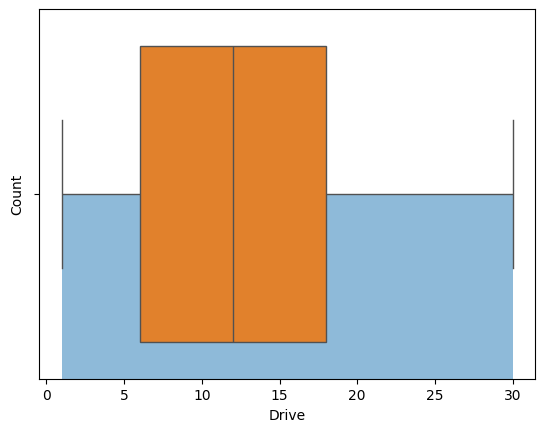

In [106]:
# football_df['Drive'].hist(bins=50)

ax = sns.histplot(football_df["Drive"], stat='count', 
			 kde=True, linewidth=0, bins=20)
ax.bar_label(ax.containers[0])


sns.boxplot(x="Drive", data=football_df)

## 3. Profiling the data

In [101]:
football_df.shape

(9992, 104)

In [48]:
football_df['DefTwoPoint'].value_counts(dropna=False)

DefTwoPoint
NaN        9990
Failure       2
Name: count, dtype: int64

In [32]:
football_df.value_counts()

Series([], Name: count, dtype: int64)

In [58]:
constant_aspect = football_df.apply(lambda col: len(col.unique()), axis=0).sort_values()[:10]
constant_aspect

Season               1
PlayAttempted        1
TwoPoint_Prob        2
sp                   2
Touchdown            2
DefTwoPoint          2
Onsidekick           2
Safety               2
Timeout_Indicator    2
RushAttempt          2
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'DefTwoPoint'),
  Text(1, 0, 'Onsidekick'),
  Text(2, 0, 'PlayAttempted'),
  Text(3, 0, 'RushAttempt'),
  Text(4, 0, 'Safety'),
  Text(5, 0, 'Season'),
  Text(6, 0, 'Timeout_Indicator'),
  Text(7, 0, 'Touchdown'),
  Text(8, 0, 'TwoPoint_Prob'),
  Text(9, 0, 'sp')])

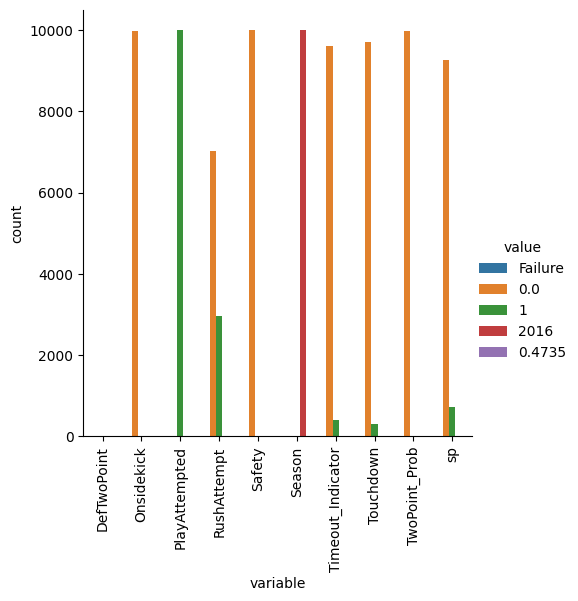

In [60]:
df_uniques = pd.melt(
    frame=football_df,
    value_vars=constant_aspect.index,
)
df_uniques

df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)
px.pl
px.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar", #height=50
)
plt.xticks(rotation='vertical')

In [62]:
football_df[constant_aspect.index].apply(lambda col: col.unique(), axis=0)

Season                       [2016]
PlayAttempted                   [1]
TwoPoint_Prob         [0.0, 0.4735]
sp                           [0, 1]
Touchdown                    [0, 1]
DefTwoPoint          [nan, Failure]
Onsidekick                   [0, 1]
Safety                       [0, 1]
Timeout_Indicator            [0, 1]
RushAttempt                  [0, 1]
dtype: object

### One-hot-encoding of categorical feature
1. Why to encode the categorical feature?
2. Why one-hot-encoding form? why not give each category in the feature a specific code value?
3. How many new features will be added? What if we have some missing values, which is the case in this dataset?
4. When is it appropriate to give each category an encoding value?


<span style="color:red"> Task : In the next cell, implement the function that take a dataframe, name of the categorical feature, and the encoder object. Then, adds new features that represent the one-hot-encoding form of this feature and ignore the missing values in it (encode them to zeros).

In [13]:
from category_encoders import OneHotEncoder
# !pip install category-encoders

cat_feats = football_df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(cols=cat_feats, handle_unknown='ignore')

encoder.fit(football_df)

# Write your code here (1 line)
# Transform the data 
encoded_data = encoder.transform(football_df)

## 4. Data Imputation
#### Imputation is filling the missing values in the dataset.
Several issues to address:
1. Why we should fill them? Why not remove the rows that has missing values?
2. Filling it with constant value for each value, but what's it?
3. (Advanced) Estimate the filling value, each row for its own.
4. How to choose the imputation strategy?
5. (Not related only to imputations) Why we fit the imputer to the training data not the concatenation of both train and test set?


<span style="color:red">Task :  In the next cell, implement a function that returns the count of nan/empty cells in a dataframe.</span><br>
<span style="color:red">Task : Use SimpleImputer object, fit it to the trainset, then transform both the train and test sets.</span>

In [14]:
from sklearn.impute import SimpleImputer
import numpy as np

#TODO: Complete a function that returns number of empty cells 
def count_nans(df):
    # 1 or 2 lines.
    return None

# Print number of empty cells (1 line)
print("#Empty missing data cells in the dataset = ", count_nans(encoded_data))

# Write your code here (3-4 lines):
# create the imputer object.
# fit the imputer.
# transform the data

print("After Imputing:")
# Print number of empty cells in the data(1 line)
print("#Empty cells in dataset =", count_nans(imputed_data))

#Empty missing data cells in the dataset =  None
After Imputing:


NameError: name 'imputed_data' is not defined

## 5. Features Scaling
1. Why we need to make all the features have same range of values?
<span style="color:blue"> This has something to do with some machine learning algorithms.
First, gradient-related algorithms (e.g., linear regression, logisitic regression, deep learning algorithms): feature scaling is important for the congergence of the algorithms as the gradient in one direction/feature could need more/long steps than the others and the scaling solves this issue and make the training stable and relatively faster.
Second, distance related algorithms (e.g., KNN, K-means). These algorithms depends on the distance between samples both in training and testing. Having features with different ranges would affect the distance measure and produce biased prediciton to the features with larger range.
for example: having two features (length in KM [10: 10000] and temperature in C° [20: 40]). The distance value will be much affected by the length feature.</span>

1. What are the different strategies to scale the features? <br>
    * <span style="color:blue">Min-Max scaling: transform all features to fall in this range: [0, 1].</span><br>
$$x_i = \frac{x_i - min(\mathbf{x})}{max(\mathbf{x}) - min(\mathbf{x})}$$
    * <span style="color:blue">Standard scaling: transform all features to have mean = 0 and standard deviation = 1. And by assuming that all features follow normal distribution, we can say that standard scaling turns featrues to be $\sim N(0,1)$.</span> <br>
$$x_i = \frac{x_i - mean(\mathbf{x})}{stdev(\mathbf{x})}$$ <br>
    * <span style="color:blue">Robust scaling: robust to the outliers that may affect the previous methods in calculating their mean, stdev, min, or max. It uses the interquartile range to scale the features according to it.
Interquartile is the range between the 1st quartile and 3rd quartile.</span> <br>
$$x_i = \frac{x_i - Q_1(\mathbf{x})}{Q_3(\mathbf{x}) - Q_1(\mathbf{x})}$$ 

3. How to choose the strategy?
<span style="color:blue">Same as in imputation strategy, using a validation set or using cross-validation.

<span style="color:red">  In the following cell, scale all the features with a scaler from your choice. Fit the scaler on the full data set and transform both it.</span>

In [9]:
from sklearn.preprocessing import RobustScaler

# Write your code here (4 lines):
# choose the scaler class.
# create the scaler object.
# fit it to the data.
# transform the data

## 6. Trainset splitting
Issues that lead to trainset splitting:
1. How we will measure the performance of our model?
<span style="color:blue"> Measuring performance on the trainset is not a good idea intuitively, as to estimate the generalization error, we need to evaluate the model on a data that wasn't seen before.
So we need to split the dataset that we have to two parts trainset and testset.
2. How we will tune the hyperparamters? Can it be done with testset?
<span style="color:blue"> If we tuned the hyperparamters on the testset, this will be considered as Data leakage as the hyperparams were tuned on the set that represent the evaluation, so there's a high chance that it will overfit the testset and fails to generalize (i.e., get high test accuracy but fails in production for example).
So, it is a must to split the data into 3 parts:
(70%) trainset to train the params , (10%) validation set to tune the hyperparameters (it can be used for other stuff like early stopping (tbe)), and (20%) testset to evaluate the model finally.

Issues to think of:
1. Is is the best strategy to get the best estimate for the true risk/performance of the system?
<span style="color:blue"> There's a chance that the testset is biased. So, a better way to estimate the true generalization error is to use cross validation.
Cross validation is a method where the dataset, is divided into k equally sized folds then we train on k-1 folds and test on the left one and repeat this process k times for each fold and get k estimates, finally we average all of these k accuracies to represent the final accuracy.
2. (Advanced) How to choose between two models?
If you have two models one with test accuracy 90% and the other with 91% (averaged from cross valdiation), which one to choose?
<span style="color:blue"> The naive/fast approach is to use the model with higher accuracy. But what if these estimates are not significantly different (we got them by chance), then a hypothesis test needs to be done.
After testing each model for each fold from the k-folds we can use "Paired t-test" to test if they are significantly different or not.
<br />(more advanced way, which is used in industry: A/B testing, watch about it [here](https://www.youtube.com/watch?v=zFMgpxG-chM))

<span style="color:red"> TASK : In the next task, you will split your data into 3 parts, train, test, and validation by ratios: 70%, 20%, and 10% respectively.</span>

In [10]:
from sklearn.model_selection import train_test_split

# TODO: Write your code here (2 lines)

print(x_train.shape, x_test.shape, x_val.shape)

(7000, 13035) (2000, 13035) (1000, 13035)


## 7. Data Visualization
Visualization is key-issue to get some insights and intuition about your dataset.
How to plot 259 features (259-dimensional data)? what we can plot -at maximum- is 2d or 3d data.

Hint: We should reduce the dimension. Read this [article](https://towardsdatascience.com/dimensionality-reduction-ways-and-intuitions-1b5e97592d8e).

So, Let's use UMAP to reduce the dimension of this dataset to be 2D.

In [11]:
from sklearn.decomposition import PCA

dim_reducer = PCA(n_components=2)
x_train_reduced = dim_reducer.fit_transform(x_train)

Let's plot the reduced dataset on a 2D plane.
Use matplotlib to make a scatter plot for the reduced dataset.

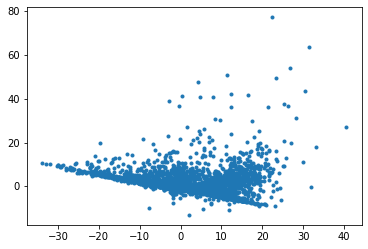

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Write code to plot the reduced dataset in a scatter plot.

## 8. Self Practice task

Using the Football dataset follow the steps below:
1. Select `Win_Prob` as target variable 
1. Remove columns with constant value (i.e all the values in the column are equal to zero)
1. Extract features from `Date` and `time` column
1. Remove all columns with more than 99% missing values
1. Remove all columns with 99% distinct values
1. Split the data into train (80%) and test(20%) sets. 
1. Split the train data into train (80%) and validation sets. 
1. Encode categorical data using a different encoder (not One Hot encoder) : see [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html) for a full list. remember that you fit the encoder on train data only and then transform test data
1. Impute missing values

<span style="color:red"> NOTE : Make use of the insights from pandas profiling report</span>